## **Исследование архитектуры ResNet на датасете CIFAR**

**Выполнил:** Скоробогатов Кирилл, ИСТ-032м

In [ ]:
import torch
import random
import numpy as np
from tqdm import tqdm
from keras.datasets import mnist
from torchsummary import summary
from torchvision import models
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import warnings
warnings.filterwarnings('ignore')

### Исследование работоспособности моделей ResNet на датасете CIFAR




In [ ]:
import torchvision.datasets

In [ ]:

CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [ ]:
X_train = torch.FloatTensor(CIFAR_train.data) 
y_train = torch.LongTensor(CIFAR_train.targets) 
X_test = torch.FloatTensor(CIFAR_test.data) 
y_test = torch.LongTensor(CIFAR_test.targets)

In [ ]:
len(y_train), len(y_test)


(50000, 10000)

In [ ]:
X_train.min(), X_train.max()


(tensor(0.), tensor(255.))

In [ ]:
X_train /= 255.
X_test /= 255.

In [ ]:
CIFAR_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

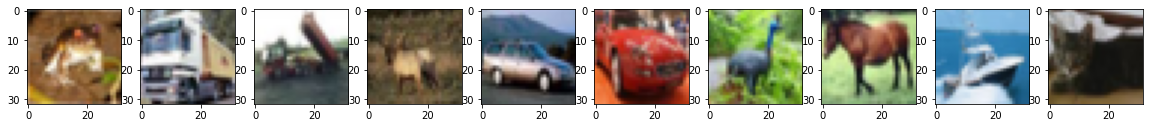

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,2)) 
for i in range(10): 
    plt.subplot(1, 10, i+1) 
    plt.imshow(X_train[i]) 
    print(y_train[i], end=' ')

In [ ]:
X_train.shape, y_train.shape


(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

In [ ]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [ ]:
def train(net, X_train, y_train, X_test, y_test, weight_decay=False, epoch_num = 15):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    if not weight_decay:
       optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    else:
       optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3, weight_decay = weight_decay)

    batch_size = 256

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(epoch_num):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            
            X_batch

        net.eval()
        with torch.no_grad():
             test_preds = net.forward(X_test)

        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)

        print(accuracy)
    del net
    return test_accuracy_history, test_loss_history

In [ ]:
accuracies = {}
losses = {}

In [ ]:
resnet_18_pretrained = models.resnet18(pretrained=True)
resnet_18 = models.resnet18() 

resnet_18_pretrained.fc = torch.nn.Linear(in_features=512, out_features=10, bias=True)
resnet_18.fc = torch.nn.Linear(in_features=512, out_features=10, bias=True)

summary(resnet_18.cuda(), (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [ ]:
resnet_18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
accuracies['resnet_18_acc'], losses['resnet_18_loss'] = train(resnet_18,X_train, y_train, X_test, y_test)
print('*'*25)
accuracies['resnet_18_acc_pretrained'], losses['resnet_18_loss_pretrained'] = train(resnet_18_pretrained,X_train, y_train, X_test, y_test)

tensor(0.5177)
tensor(0.5872)
tensor(0.6458)
tensor(0.6648)
tensor(0.6886)
tensor(0.7154)
tensor(0.7247)
tensor(0.7086)
tensor(0.7008)
tensor(0.7107)
tensor(0.7084)
tensor(0.7220)
tensor(0.7380)
tensor(0.6984)
tensor(0.7272)
tensor(0.7321)
tensor(0.7314)
tensor(0.7287)
tensor(0.7228)
tensor(0.7347)
tensor(0.7428)
tensor(0.7102)
tensor(0.7312)
tensor(0.7226)
tensor(0.7357)
tensor(0.7342)
tensor(0.7408)
tensor(0.7357)
tensor(0.7286)
tensor(0.7392)
tensor(0.7460)
tensor(0.7369)
tensor(0.7032)
tensor(0.7530)
tensor(0.7318)
tensor(0.7432)
tensor(0.7466)
tensor(0.7242)
tensor(0.7439)
tensor(0.7330)
tensor(0.7342)
tensor(0.7403)
tensor(0.7431)
tensor(0.7209)
tensor(0.7359)
tensor(0.7453)
tensor(0.7243)
tensor(0.7518)
tensor(0.7187)
tensor(0.7443)
*************************
tensor(0.7574)
tensor(0.7707)
tensor(0.7771)
tensor(0.7780)
tensor(0.7868)
tensor(0.7824)
tensor(0.7987)
tensor(0.7781)
tensor(0.8044)
tensor(0.8078)
tensor(0.8129)
tensor(0.8111)
tensor(0.8099)
tensor(0.8126)
tensor(0.8089)

In [ ]:
def print_accuracy_plot(accuracies):
    for experiment_id in accuracies.keys():
        max_accuracy = max(accuracies[experiment_id])
        index_max_accuracy = accuracies[experiment_id].index(max_accuracy)
        plt.plot(accuracies[experiment_id], label=experiment_id)
        plt.scatter(index_max_accuracy, max_accuracy, marker='o', label =f'Макс. знач. точности ({max_accuracy:.4f})')

    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.xlabel('\nЭпохи обучения')
    plt.ylabel('Точность распознавания\n')
    plt.title('Validation Accuracy\n');

def print_loss_plot(losses):
    for experiment_id in losses.keys():
        plt.plot(losses[experiment_id], label=experiment_id)
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.xlabel('\nЭпохи обучения')
    plt.ylabel('Точность распознавания\n')
    plt.title('Validation Loss\n');

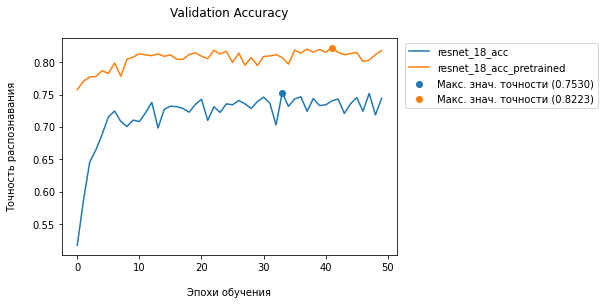

In [ ]:
# print_accuracy_plot(accuracies)

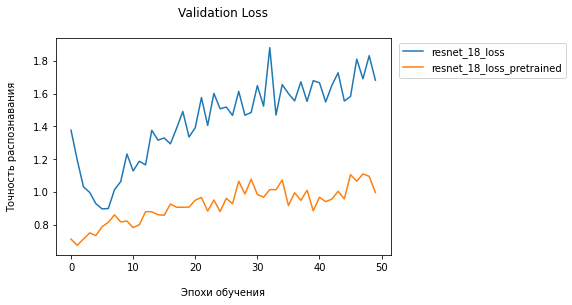

In [ ]:
# print_loss_plot(losses)

In [ ]:
class LambdaLayer(torch.nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(torch.nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A', 
                 use_batch_norm=True, use_drop_out=False, d_out_p=0.5):
        super(BasicBlock, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_drop_out = use_drop_out
        self.d_out_p = d_out_p
        self.act  = torch.nn.ReLU()
        
        self.conv1 = torch.nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.d_out1 = torch.nn.Dropout2d(d_out_p)
        self.conv2 = torch.nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(planes)
        self.d_out2 = torch.nn.Dropout2d(d_out_p)

        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """https://www.kaggle.com/mrtahion/kernel63a29c282a?scriptVersionId=17181076
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x: torch.nn.functional.pad(x[:, :, ::2, ::2], \
                                            (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     torch.nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     torch.nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = self.conv1(x)
        if self.use_batch_norm:
            out = self.bn1(out)
        if self.use_drop_out:
            out = self.d_out1(out) 
        out = self.act(out)
        out = self.conv2(out)
        
        if self.use_batch_norm:
            out = self.bn2(out)
        if self.use_drop_out:
            out = self.d_out2(out)
          
        out += self.shortcut(x)
        out = self.act(out)
        return out


class ResNet(torch.nn.Module):
    def __init__(self, block, num_blocks, num_classes=10,
                 use_batch_norm=True, use_drop_out=False, d_out_p=0.5):
        super(ResNet, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_drop_out = use_drop_out
        self.d_out_p = d_out_p
        self.in_planes = 16
        self.act  = torch.nn.ReLU()

        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.d_out1 = torch.nn.Dropout2d(d_out_p)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = torch.nn.Linear(64, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride,
                                use_batch_norm=self.use_batch_norm,
                               use_drop_out=self.use_drop_out, 
                               d_out_p=self.d_out_p))
            self.in_planes = planes * block.expansion

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        if self.use_batch_norm:
            out = self.bn1(out)
        if self.use_drop_out:
            out = self.d_out1(out)
          
        out = self.act(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = torch.nn.functional.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
        

In [ ]:
def resnet110():
    return ResNet(BasicBlock, [18, 18, 18])
  
def resnet110_no_bn():
    return ResNet(BasicBlock, [18, 18, 18], use_batch_norm=False) 

def resnet110_d_out15():
    return ResNet(BasicBlock, [18, 18, 18], use_drop_out=True, d_out_p=0.15)
  
def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])  
  
def resnet20_d_out5():
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True)
  
def resnet20_d_out3(**kwargs):
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True, d_out_p=0.3)
  
def resnet20_d_out8():
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True, d_out_p=0.8)
  
def resnet20_d_out15():
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True, d_out_p=0.15)

### **ResNet20**

In [ ]:
# accuracies, losses = {}, {}

# accuracies['resnet20_dropout_0_15'], losses['resnet20_dropout_0_15'] = \
#     train(resnet20_d_out15(), X_train, y_train, X_test, y_test)

# print('\n-----------\n')

# accuracies['resnet20_dropout_0_3'], losses['resnet20_dropout_0_3'] = \
#     train(resnet20_d_out3(), X_train, y_train, X_test, y_test)

# print('\n-----------\n')   

# accuracies['resnet20_dropout_0_5'], losses['resnet20_dropout_0_5'] = \
#     train(resnet20_d_out5(), X_train, y_train, X_test, y_test)

# print('\n-----------\n')

# accuracies['resnet20_dropout_0_8'], losses['resnet20_dropout_0_8'] = \
#     train(resnet20_d_out8(), X_train, y_train, X_test, y_test)



tensor(0.4718)
tensor(0.5406)
tensor(0.5890)
tensor(0.6355)
tensor(0.6667)
tensor(0.6915)
tensor(0.7091)
tensor(0.7250)
tensor(0.7527)
tensor(0.7619)
tensor(0.7697)
tensor(0.7777)
tensor(0.7913)
tensor(0.7908)
tensor(0.7955)
tensor(0.8019)
tensor(0.8074)
tensor(0.8125)
tensor(0.8162)
tensor(0.8151)
tensor(0.8191)
tensor(0.8160)
tensor(0.8219)
tensor(0.8302)
tensor(0.8277)
tensor(0.8326)
tensor(0.8305)
tensor(0.8313)
tensor(0.8325)
tensor(0.8370)

-----------

tensor(0.3282)
tensor(0.4110)
tensor(0.4429)
tensor(0.4685)
tensor(0.4818)
tensor(0.5088)
tensor(0.5460)
tensor(0.5609)
tensor(0.5857)
tensor(0.6004)
tensor(0.6112)
tensor(0.6298)
tensor(0.6402)
tensor(0.6622)
tensor(0.6629)
tensor(0.6734)
tensor(0.6901)
tensor(0.7060)
tensor(0.7050)
tensor(0.7186)
tensor(0.7310)
tensor(0.7307)
tensor(0.7416)
tensor(0.7542)
tensor(0.7533)
tensor(0.7543)
tensor(0.7614)
tensor(0.7594)
tensor(0.7676)
tensor(0.7703)

-----------

tensor(0.1934)
tensor(0.2467)
tensor(0.2891)
tensor(0.3246)
tensor(0.313

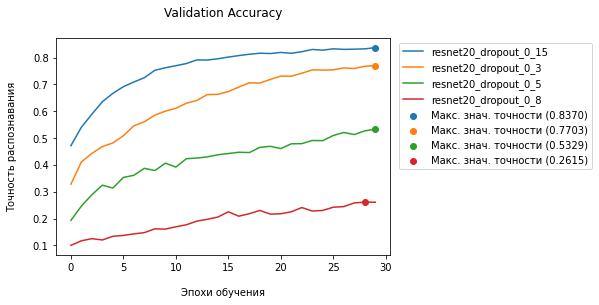

In [ ]:
# print_accuracy_plot(accuracies)

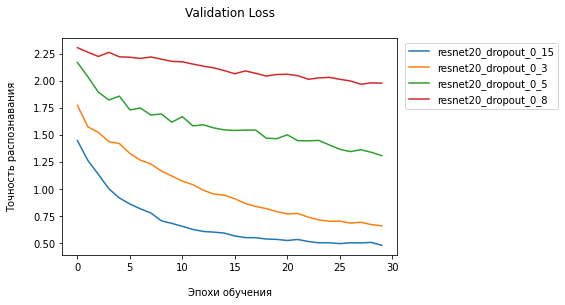

In [ ]:
# print_loss_plot(losses)

In [ ]:
# accuracies, losses = {}, {}
# for i in [1e-3, 1e-4, 1e-5]:
#   accuracies[f'resnet20_without_dropout_weight_decay_{i}'], losses[f'resnet20_without_dropout_weight_decay_{i}'] = \
#     train(resnet20_d_out15(), X_train, y_train, X_test, y_test, i)
  
#   print('\n----------\n')

tensor(0.4564)
tensor(0.5402)
tensor(0.5913)
tensor(0.6471)
tensor(0.6414)
tensor(0.7143)
tensor(0.7362)
tensor(0.7372)
tensor(0.7586)
tensor(0.7784)
tensor(0.7823)
tensor(0.7893)
tensor(0.7957)
tensor(0.8003)
tensor(0.8082)
tensor(0.8093)
tensor(0.8175)
tensor(0.8165)
tensor(0.8233)
tensor(0.8239)
tensor(0.8280)
tensor(0.8221)
tensor(0.8177)
tensor(0.8125)
tensor(0.8270)
tensor(0.8319)
tensor(0.8365)
tensor(0.8299)
tensor(0.8231)
tensor(0.8336)

----------

tensor(0.4612)
tensor(0.5268)
tensor(0.5946)
tensor(0.6007)
tensor(0.6699)
tensor(0.6887)
tensor(0.6945)
tensor(0.7263)
tensor(0.7385)
tensor(0.7559)
tensor(0.7652)
tensor(0.7831)
tensor(0.7650)
tensor(0.7914)
tensor(0.8025)
tensor(0.7968)
tensor(0.7966)
tensor(0.8006)
tensor(0.8108)
tensor(0.8224)
tensor(0.8214)
tensor(0.8199)
tensor(0.8276)
tensor(0.8306)
tensor(0.8239)
tensor(0.8295)
tensor(0.8276)
tensor(0.8312)
tensor(0.8350)
tensor(0.8327)

----------

tensor(0.4123)
tensor(0.5104)
tensor(0.5963)
tensor(0.6270)
tensor(0.6752)

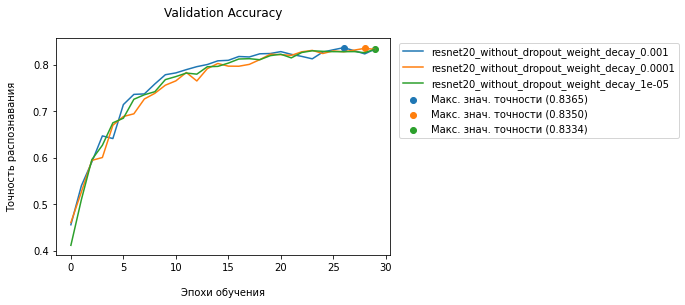

In [ ]:
# print_accuracy_plot(accuracies)

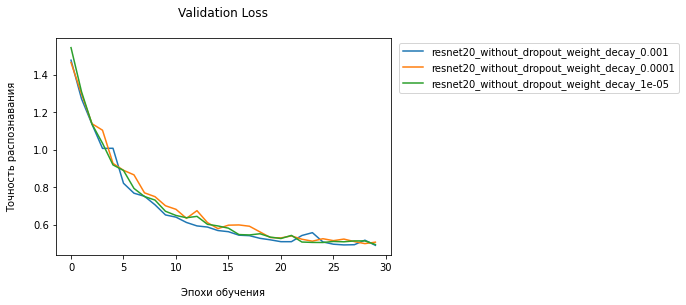

In [ ]:
# print_loss_plot(losses)

In [ ]:
# accuracies, losses = {}, {}

# accuracies['resnet110'], losses['resnet110'] = \
#     train(resnet110(), X_train, y_train, X_test, y_test, epoch_num=25)

# print('\nТесты без батч-нормализации:')

# for i in range(10):
#   print(f'Тест №{i}')
#   accuracies[f'resnet110_no_bn_test{i}'], losses[f'resnet110_no_bn_test{i}'] = \
#     train(resnet110_no_bn(), X_train, y_train, X_test, y_test)
#   print('\n--------------\n')  

tensor(0.5601)
tensor(0.6573)
tensor(0.7332)
tensor(0.7518)
tensor(0.7770)
tensor(0.7477)
tensor(0.7356)
tensor(0.7917)
tensor(0.7213)
tensor(0.7383)
tensor(0.7989)
tensor(0.7602)
tensor(0.7352)
tensor(0.7280)
tensor(0.8071)
tensor(0.7964)
tensor(0.7596)
tensor(0.8038)
tensor(0.7959)
tensor(0.8108)
tensor(0.7866)
tensor(0.7528)
tensor(0.7923)
tensor(0.7831)
tensor(0.8080)

Тесты без батч-нормализации:
Тест №0
tensor(0.2096)
tensor(0.3322)
tensor(0.4090)
tensor(0.5022)
tensor(0.5598)
tensor(0.5974)
tensor(0.6149)
tensor(0.6460)
tensor(0.6504)
tensor(0.6835)
tensor(0.6761)
tensor(0.6924)
tensor(0.6808)
tensor(0.7042)
tensor(0.7019)

--------------

Тест №1
tensor(0.3009)
tensor(0.4090)
tensor(0.4658)
tensor(0.4975)
tensor(0.5423)
tensor(0.5715)
tensor(0.5881)
tensor(0.6095)
tensor(0.6147)
tensor(0.6304)
tensor(0.6219)
tensor(0.6355)
tensor(0.6369)
tensor(0.6321)
tensor(0.6358)

--------------

Тест №2
tensor(0.3514)
tensor(0.4268)
tensor(0.5065)
tensor(0.5542)
tensor(0.6253)
tensor(0.663

In [ ]:
accuracies['resnet110'] = [0.5601, 0.6573, 0.7332, 0.7518, 0.7770, 0.7477, 0.7356,0.7917,0.7213, 0.7383, 0.7989,0.7602, 0.7352, 0.7280, 0.8071]
accuracies['resnet110_no_bn_test_1'] = [0.2096,0.3322,0.4090,0.5022,0.5598,0.5974,0.6149,0.6460,0.6504,0.6835,0.6761,0.6924,0.6808,0.7042,0.7019]
accuracies['resnet110_no_bn_test_2'] = [0.3009,0.4090,0.4658,0.4975,0.5423,0.5715,0.5881,0.6095,0.6147,0.6304,0.6219,0.6355,0.6369,0.6321,0.6358]
accuracies['resnet110_no_bn_test_3'] = [0.3514,0.4268,0.5065,0.5542,0.6253,0.6636,0.6899,0.6758,0.6983,0.7157,0.7101,0.7128,0.7204,0.7050,0.7000]
accuracies['resnet110_no_bn_test_4'] = [0.2957,0.3778,0.4349,0.5268,0.5599,0.5961,0.6043,0.6318,0.6697,0.6791,0.6873,0.6999,0.6957,0.7193,0.6838]

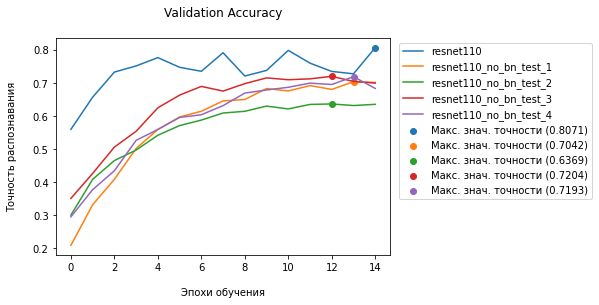

In [ ]:
print_accuracy_plot(accuracies)

In [ ]:
# print_loss_plot(losses)